<a href="https://colab.research.google.com/github/allnes/age_classifier/blob/master/dna_problem/ASW_GWD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect to Google Drive

In [3]:
%tensorflow_version 1.x

from google.colab import drive
import os, natsort as nsrt, numpy as np, re
from scipy.sparse import coo_matrix, csgraph, csr_matrix
import matplotlib.pyplot as plt
import cv2 as cv
import scipy
!pip install -U scikit-learn
import sklearn
import math
drive.mount('/content/drive')
PATH_PROJECT='/content/drive/My Drive/DL_DATA_GRAPH/'
PATH_CNN_REPO=PATH_PROJECT + 'BUILD/cnn_graph/'
os.chdir(PATH_CNN_REPO)
from lib import models, graph, coarsening, utils
%ls

# !git clone https://github.com/mdeff/cnn_graph
!git pull origin master

os.chdir(PATH_PROJECT)
%ls
%matplotlib inline

TensorFlow 1.x selected.
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
checkpoints/  makefile    README.md         trials/
lib/          nips2016/   requirements.txt  usage.ipynb
LICENSE.txt   rcv1.ipynb  summaries/
From https://github.com/allnes/cnn_graph
 * branch            master     -> FETCH_HEAD
Already up to date.
BUILD/  DATA/


## Preprocessing data

(174, 16384)
['arr_0', 'arr_1']
(174, 16384)
(174,)
--> Reshape data


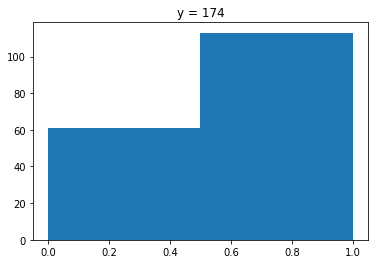

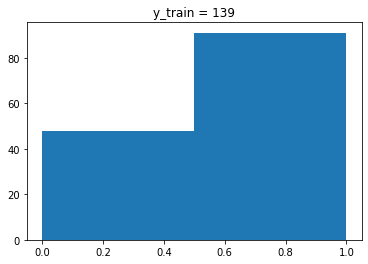

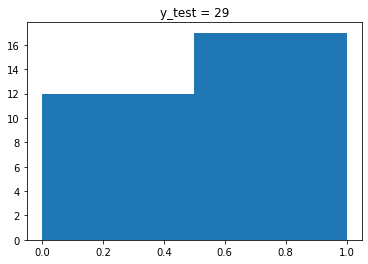

[0. 1.]
--> Get distance graph
d = |V| = 128, k|V| < |E| = 193296


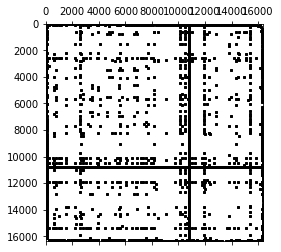

In [4]:
flag_save_dump = True
name_region = 'ASW_GWD'

def save_matrix(zip_sz):
    PATH_CONVERTED_SAVE_DATA = PATH_PROJECT + 'DATA/DNA_DATA/raw/{}.npz'.format(name_region)
    npzfile = np.load(PATH_CONVERTED_SAVE_DATA)
    X_full = npzfile['arr_0'].astype(np.float32)
    y_full = npzfile['arr_1']
    X = []
    for graph in X_full:
        graph_size = int(math.sqrt(graph.shape[0]))
        new_graph = np.copy(graph).reshape(graph_size, graph_size)
        new_graph = np.pad(new_graph, pad_width=1, mode='constant', constant_values=0)
        X.append(cv.resize(new_graph, 
                           dsize=(zip_sz, zip_sz), 
                           interpolation=cv.INTER_CUBIC))
    X = np.array(X)
    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
    print(X.shape)
    PATH_CONVERTED_SAVE_DATA = PATH_PROJECT + 'DATA/DNA_DATA/resize/{}_{}.npz'.format(name_region, zip_sz)
    np.savez(PATH_CONVERTED_SAVE_DATA, X, y_full)

zip_size = 128

if flag_save_dump:
    save_matrix(zip_size)

PATH_CONVERTED_DATA = PATH_PROJECT + 'DATA/DNA_DATA/resize/{}_{}.npz'.format(name_region, zip_size)

npzfile = np.load(PATH_CONVERTED_DATA)
print(npzfile.files)
X = npzfile['arr_0'].astype(np.float32)
y = npzfile['arr_1']
num_samples = X.shape[0]
print(X.shape)
print(y.shape)

from sklearn.utils import shuffle
X, y = shuffle(X, y)

##########################################################

print('--> Reshape data')
n_train = (num_samples * 4) // 5
n_val = num_samples // 25

X_train = X[:n_train]
X_val   = X[n_train:n_train+n_val]
X_test  = X[n_train+n_val:]

y_train = y[:n_train]
y_val   = y[n_train:n_train+n_val]
y_test  = y[n_train+n_val:]

plt.title("y = {}".format(y.shape[0]))
plt.hist(y, len(np.unique(y)))
plt.show()

plt.title("y_train = {}".format(y_train.shape[0]))
plt.hist(y_train, len(np.unique(y_train)))
plt.show()

plt.title("y_test = {}".format(y_test.shape[0]))
plt.hist(y_test, len(np.unique(y_test)))
plt.show()
print(np.unique(y))

##########################################################

def save_dump():
    print('--> Get distance graph')
    def distance_sklearn_metrics(z, k=6, metric='euclidean'):
        """Compute exact pairwise distances."""
        d = sklearn.metrics.pairwise.pairwise_distances(
                z, metric=metric, n_jobs=-2)
        # k-NN graph.
        idx = np.argsort(d)[:, 1:k+1]
        d.sort()
        d = d[:, 1:k+1]
        return d, idx

      
    dist, idx = distance_sklearn_metrics(X_train.T)
    A = graph.adjacency(dist, idx).astype(np.float32)

    PATH_DUMP_DATA = PATH_PROJECT + 'DATA/DNA_DATA/dump/{}_dump.npz'.format(name_region)
    scipy.sparse.save_npz(PATH_DUMP_DATA, A)

if flag_save_dump:
    save_dump()

PATH_DUMP_LOAD_DATA = PATH_PROJECT + 'DATA/DNA_DATA/dump/{}_dump.npz'.format(name_region)
A = scipy.sparse.load_npz(PATH_DUMP_LOAD_DATA)


print('d = |V| = {}, k|V| < |E| = {}'.format(zip_size, A.nnz))
plt.spy(A, markersize=2, color='black');

## Train

In [5]:
print('--> Get laplacian matrix')
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=True)
X_train = coarsening.perm_data(X_train, perm)
print(X_train.shape)
X_val = coarsening.perm_data(X_val, perm)
print(X_val.shape)
X_test = coarsening.perm_data(X_test, perm)
print(X_test.shape)

--> Get laplacian matrix


/content/drive/My Drive/DL_DATA_GRAPH/BUILD/cnn_graph/lib/coarsening.py:152: RuntimeWarning: divide by zero encountered in true_divide
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])
/content/drive/My Drive/DL_DATA_GRAPH/BUILD/cnn_graph/lib/coarsening.py:152: RuntimeWarning: divide by zero encountered in true_divide
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])


Layer 0: M_0 = |V| = 127528 nodes (111144 added),|E| = 96648 edges
Layer 1: M_1 = |V| = 63764 nodes (47577 added),|E| = 96519 edges
Layer 2: M_2 = |V| = 31882 nodes (15830 added),|E| = 96160 edges
Layer 3: M_3 = |V| = 15941 nodes (0 added),|E| = 95714 edges
(139, 127528)
(6, 127528)
(29, 127528)


In [0]:
L = [graph.laplacian(A, normalized=True) for A in graphs]

In [0]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 64
params['batch_size']     = 16
params['eval_frequency'] = 100

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['brelu']          = 'b2relu'
params['pool']           = 'apool1'
params['pool']           = 'mpool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [32, 32]  # Number of graph convolutional filters.
params['K']              = [16, 16]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [2000, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0
params['decay_steps']    = n_train / params['batch_size']

In [8]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 127528
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 127528 * 32 / 4 = 1020224
    weights: F_0 * F_1 * K_1 = 1 * 32 * 16 = 512
    biases: M_1 * F_1 = 127528 * 32 = 4080896
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 31882 * 32 / 2 = 510112
    weights: F_1 * F_2 * K_2 = 32 * 32 * 16 = 16384
    biases: M_2 * F_2 = 31882 * 32 = 1020224
  layer 3: fc1
    representation: M_3 = 2000
    weights: M_2 * M_3 = 510112 * 2000 = 1020224000
    biases: M_3 = 2000
  layer 4: logits (softmax)
    representation: M_4 = 2.0
    weights: M_3 * M_4 = 2000 * 2.0 = 4000.0
    biases: M_4 = 2.0







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.








step 100 / 556 (epoch 11.51 / 64):
  learning_rate = 5.69e-04, loss_average = 1.97e+03
  validation accuracy: 16.67 (1 / 6), f1 (weighted): 4.76, loss: 5.26e+03
  time: 6150s (wall

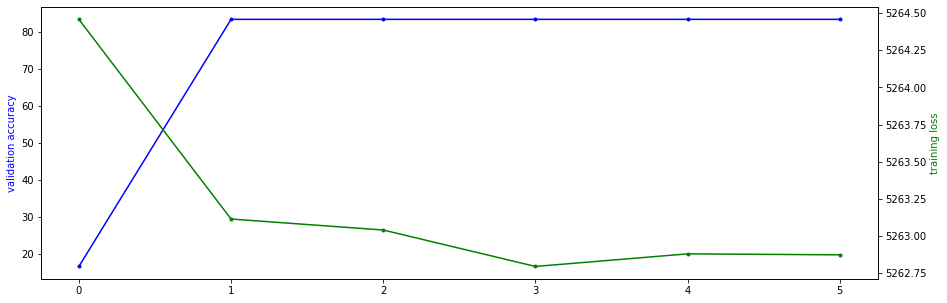

In [9]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [10]:
print('Time per step: {:.2f} ms'.format(t_step*1000))

Time per step: 4634.06 ms


In [11]:
print(X_test.shape, y_test.shape)
acc_per_class = {}
for id_class in np.unique(y):
    acc_per_class[id_class] = []

for graph, label in zip(X_test, y_test):
    acc_per_class[label].append(graph)


for id_class in np.unique(y):
    acc_per_class[id_class] = np.array(acc_per_class[id_class])
    acc_hape = acc_per_class[id_class].shape
    labels = np.empty(acc_hape[0])
    labels.fill(id_class)
    print("############ Class {}".format(id_class))
    print(acc_hape)
    print(model.evaluate(acc_per_class[id_class], labels)[0])


(29, 127528) (29,)
############ Class 0.0
(12, 127528)
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/DL_DATA_GRAPH/BUILD/cnn_graph/lib/../checkpoints/demo/model-556
accuracy: 8.33 (1 / 12), f1 (weighted): 15.38, loss: 2.63e+03
time: 28s (wall 6s)
############ Class 1.0
(17, 127528)
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/DL_DATA_GRAPH/BUILD/cnn_graph/lib/../checkpoints/demo/model-556
accuracy: 94.12 (16 / 17), f1 (weighted): 96.97, loss: 3.71e+03
time: 33s (wall 7s)


In [12]:
res = model.evaluate(X_test, y_test)
print(res[0])

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/DL_DATA_GRAPH/BUILD/cnn_graph/lib/../checkpoints/demo/model-556
accuracy: 58.62 (17 / 29), f1 (weighted): 48.54, loss: 2.18e+03
time: 35s (wall 39s)
